In [1]:
#LIBRARY

import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import  OneHotEncoder, RobustScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
from scipy.stats import uniform

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, fbeta_score

# save modeling
import pickle

# shap
import shap

# # remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
rs = 42

<img src="EZORA.png" alt="EZORA" style="width:100%; height:auto;">

**“Disclaimer: This project is based on a fictional company and is intended solely for study purposes.”**


<hr style="border: 3px; height: 10px; background-color: #050A30;"> <!-- Colored line -->


Table of Contents: 

1. [Business Understanding and Project Introduction](#1-business-problem-understanding)
    * [Business Context](#11-business-context)
    * [Business Problem](#12-business-problem)
    * [Objective](#13-objective)
    * [Metric Evaluation](#14-metric-evaluation)
    * [Analytic Approach](#15-analytic-approach)
2. [Data Understanding](#2-data-understanding)
3. [Data Cleaning and Preprocessing](#3-data-cleaning--preprocessing)
4. [Modeling](#4-model-selection)
5. [Conclusion and Recommendation](#5-conclusion-and-recommendation)

<hr style="border: 3px; height: 10px; background-color: #050A30;"> <!-- Colored line -->


## 1. Business Problem Understanding


### 1.1 Business Context

<p style="text-align: justify;">
Ezora is one of the leading e-commerce platforms in India, founded in 2019. The company thrived during the pandemic period, which significantly shifted consumer behavior toward online shopping. Ezora quickly grew its customer base and benefited from substantial investments, a large portion of which was allocated to its marketing budget. These funds helped drive aggressive campaigns that focused on both acquiring and retaining customers.<br><br>
However, in 2024, the global economic condition is unstable, and Ezora is not immune to its effects. Financial pressures have tightened the company’s funding, and Ezora must now budget its resources more carefully. One of the main concerns is the marketing budget. The cost of getting new customers has gone up a lot, as of now Ezora spend between INR 1200 and INR 1500 for each new customer, which is very expensive. [1]<br><br>
In this competitive e-commerce landscape, retaining customers is proven to be more cost-effective than acquiring new ones. Loyal customers not only bring consistent revenue but also tend to make repeat purchases, increasing their lifetime value.<br><br>
However, Ezora’s current customer retention strategy involves blanket campaigns which done an undifferentiated approach in marketing and targeting all existing customers. This method worked when the company had plenty of funding, but it’s not a good fit for the current situation where money is tight and under financial pressures.<br><br>
To deal with this, Ezora needs a smarter and more focused approach. The company should focus on finding customers who are most likely to stop using the platform. By targeting these churn-risk customers, the marketing team can allocate their budget more wisely and offering retention campaigns only where they are most needed.<br><br>
This project focuses on creating a churn prediction model to help Ezora’s marketing team identify churn-risk customers and intervene effectively.
</p>

### 1.2 Business Problem

Ezora is facing financial challenges and can no longer afford to apply blanket retention campaigns to all customers. 

**The main stakeholder for this project is Ezora marketing department.**<br><br>
**Business problem :**

- Ezora lacks a focused approach to identify churn-risk customers, resulting in an inefficient use of the marketing budget, with estimated INR 1500 spent on acquiring a new customer and an estimated 17% churn rate each month occurs among existing customers.

**Why solving this problem is crucial :**

1.	High Acquisition Costs: INR 1500 per new customer makes acquisition unsustainable in current economic conditions.

2.	Significant Customer Loss: Monthly churn rate of 17% undermines revenue and reduces the value of marketing efforts.

3. Optimized Resource Allocation: Transitioning from blanket marketing to targeted strategies saves costs and improves impact.

### 1.3 Objective

**Develop a churn prediction model to predict whether a customer will churn.** 

Ezora aims to prioritize identifying at-risk customers, enabling the marketing team to allocate retention budgets more effectively and prevent churn among these customers.

### 1.4 Metric Evaluation

The performance of the churn prediction model can be evaluated using the **confusion matrix**, structured as follows:

|                          | **Predicted: No Churn** | **Predicted: Churn** |
|--------------------------|--------------------------|-----------------------|
| **Actual: No Churn**     | **True Negatives (TN):** Non-churners correctly identified | **False Positives (FP):** Non-churners incorrectly flagged as churners |
| **Actual: Churn**        | **False Negatives (FN):** Churners missed by the model | **True Positives (TP):** Correctly identified churners |

- **False Positives (FP) - Type I Error**:  Customers incorrectly predicted to churn, leading to unnecessary retention efforts.  
  **Consequence**: Marketing budget loss. Retention efforts such as discounts and promotional offers are wasted on loyal customers who would have continued using Ezora’s services without these incentives. This reduces the cost-efficiency of the marketing budget.

- **False Negatives (FN) - Type II Error**: Customers who actually churned but were missed by the model.  
  **Consequence**: Revenue loss. Retention efforts are not directed toward customers who would have stayed if targeted by the marketing team. This results in losing valuable customers and their future purchases, directly impacting Ezora’s revenue.

While there is no universally best metric across all e-commerce, this project focuses on **F2 Score.**

In Ezora’s case, while identifying as many churn-risk customers as possible is a priority, it’s also important to ensure that the **marketing budget isn’t wasted on too many false positives (non-churners being incorrectly flagged as churn-risk).**

The F2 score is a weighted version of the F1 score that gives more importance to recall while still considering precision. The F2 score provides a balance, allowing the marketing team to target a majority of churn-risk customers while keeping false positives at a manageable level.

Retention campaigns come at a cost, and targeting too many false positives can strain the limited marketing budget. The F2 score ensures that the model maximizes recall but does not completely disregard precision, making it a better fit for Ezora’s need to balance budget efficiency.


#### F2 Score Formula

The general formula for the F-beta score is:

$$
F_{\beta} = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}
$$

---

When \(beta = 2\), the formula becomes:

$$
F_2 = (1 + 2^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(2^2 \cdot \text{Precision}) + \text{Recall}}
$$

Simplified:

$$
F_2 = 5 \cdot \frac{\text{Precision} \cdot \text{Recall}}{(4 \cdot \text{Precision}) + \text{Recall}}
$$

---

#### Precision

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

- **Definition**: Measures how many of the predicted positives are actually correct.

---

#### Recall

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

- **Definition**: Measures how many of the actual positives are correctly identified by the model.

#### How the F2 Score Balances Precision and Recall

•	Precision: Focuses on reducing false positives (FP).

•	Recall: Focuses on reducing false negatives (FN).

•	F2 Score: Emphasizes recall (FN) by giving it 4x the weight of precision.

#### Justification : 

•	A higher F2 score (closer to 1.0) means the model achieves a good balance between precision and recall, but with greater success in capturing true positives (high recall).

•	A lower F2 score (closer to 0.0) indicates poor performance, with either precision or recall (or both) being low.

**Target Description**

| **Churn (Target)** | **Description**      |
|:------------------:|:--------------------:|
| 0                  | Customer did not churn |
| 1                  | Customer churned       |

### 1.5 Analytic Approach

The process are:
1. **Data Analysis and Feature Selection**:
   - Analyzing the dataset and feature to gain insights.

2. **Model Development**:
   - Building a classification model that predicts the churn or not-churn of the customer.
   - Evaluating multiple machine learning algorithms to identify the best-performing model.

3. **Optimization**:
   - Tuning the model to maximize **F2-score** as a key metric to prioritize recall over precision, aligning with the goal of reducing missed churners.

4. **Implementation**:
   - Using the model's predictions to enable the marketing and retention teams to target churn-risk customers effectively.

This project goal is to build a reliable prediction system that allows Ezora to take proactive steps in improving retention efforts.

<hr style="border: 3px; height: 10px; background-color: #050A30;"> <!-- Colored line -->


## 2. Data Understanding


This dataset belongs to Ezora, an e-commerce company, and contains information about customers who are registered for the past 60 months or have made purchases on Ezora for the past 30 days.

Limitation :
* The data currently available for customers tenure ≤ 60 months and recent activities (≤ 30 days), so the data will be limited to this time range.

### Load Data

In [3]:
df = pd.read_csv("data_ecommerce_customer_churn.csv")
df.sample(5)

Tenure  WarehouseToHome  NumberOfDeviceRegistered PreferedOrderCat  \
2642     NaN             22.0                         5           Mobile   
2396    20.0              9.0                         4           Others   
2700     1.0             23.0                         4     Mobile Phone   
2983     1.0             16.0                         5     Mobile Phone   
390      1.0             10.0                         4     Mobile Phone   

      SatisfactionScore MaritalStatus  NumberOfAddress  Complain  \
2642                  5       Married                2         1   
2396                  5        Single                5         0   
2700                  4       Married                4         1   
2983                  5        Single                2         1   
390                   5        Single                2         0   

      DaySinceLastOrder  CashbackAmount  Churn  
2642                0.0          123.07      1  
2396                2.0          314.47      0  
2700                3.0          148.73      1  
2983                3.0          148.21      1  
390                 5.0          156.02      1

### Dataset Features Description

| **Feature**               | **Type**   | **Description**                                              |
|---------------------------|------------|--------------------------------------------------------------|
| `Tenure`                 | Float      | Tenure of a customer in the company (0-60 months)                         |
| `WarehouseToHome`        | Float      | Distance between the warehouse and the customer's home       |
| `NumberOfDeviceRegistered` | Integer   | Total number of devices registered for a particular customer |
| `PreferedOrderCat`       | Object     | Preferred order category of a customer in the last month     |
| `SatisfactionScore`      | Integer    | Satisfaction score of a customer on service                 |
| `MaritalStatus`          | Object     | Marital status of a customer                                |
| `NumberOfAddress`        | Integer    | Total number of addresses added for a particular customer   |
| `Complaint`              | Integer    | Indicates if any complaint was raised in the last month      |
| `DaySinceLastOrder`      | Float      | Days since the customer's last order (0-30 days)                        |
| `CashbackAmount`         | Float      | Average cashback received by the customer in the last month |
| `Churn`                  | Integer    | Churn flag (1 for churned, 0 for not churned)               |

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


### EDA


In [5]:
profile = ProfileReport(df, title="E-Commerce Churn Profiling Report", explorative=True)

In [6]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# List of numerical columns to compare with 'Tenure'
numerical_columns_to_compare = ['WarehouseToHome', 'NumberOfDeviceRegistered', 
                                'SatisfactionScore', 'NumberOfAddress', 
                                'DaySinceLastOrder', 'CashbackAmount', 'Tenure']

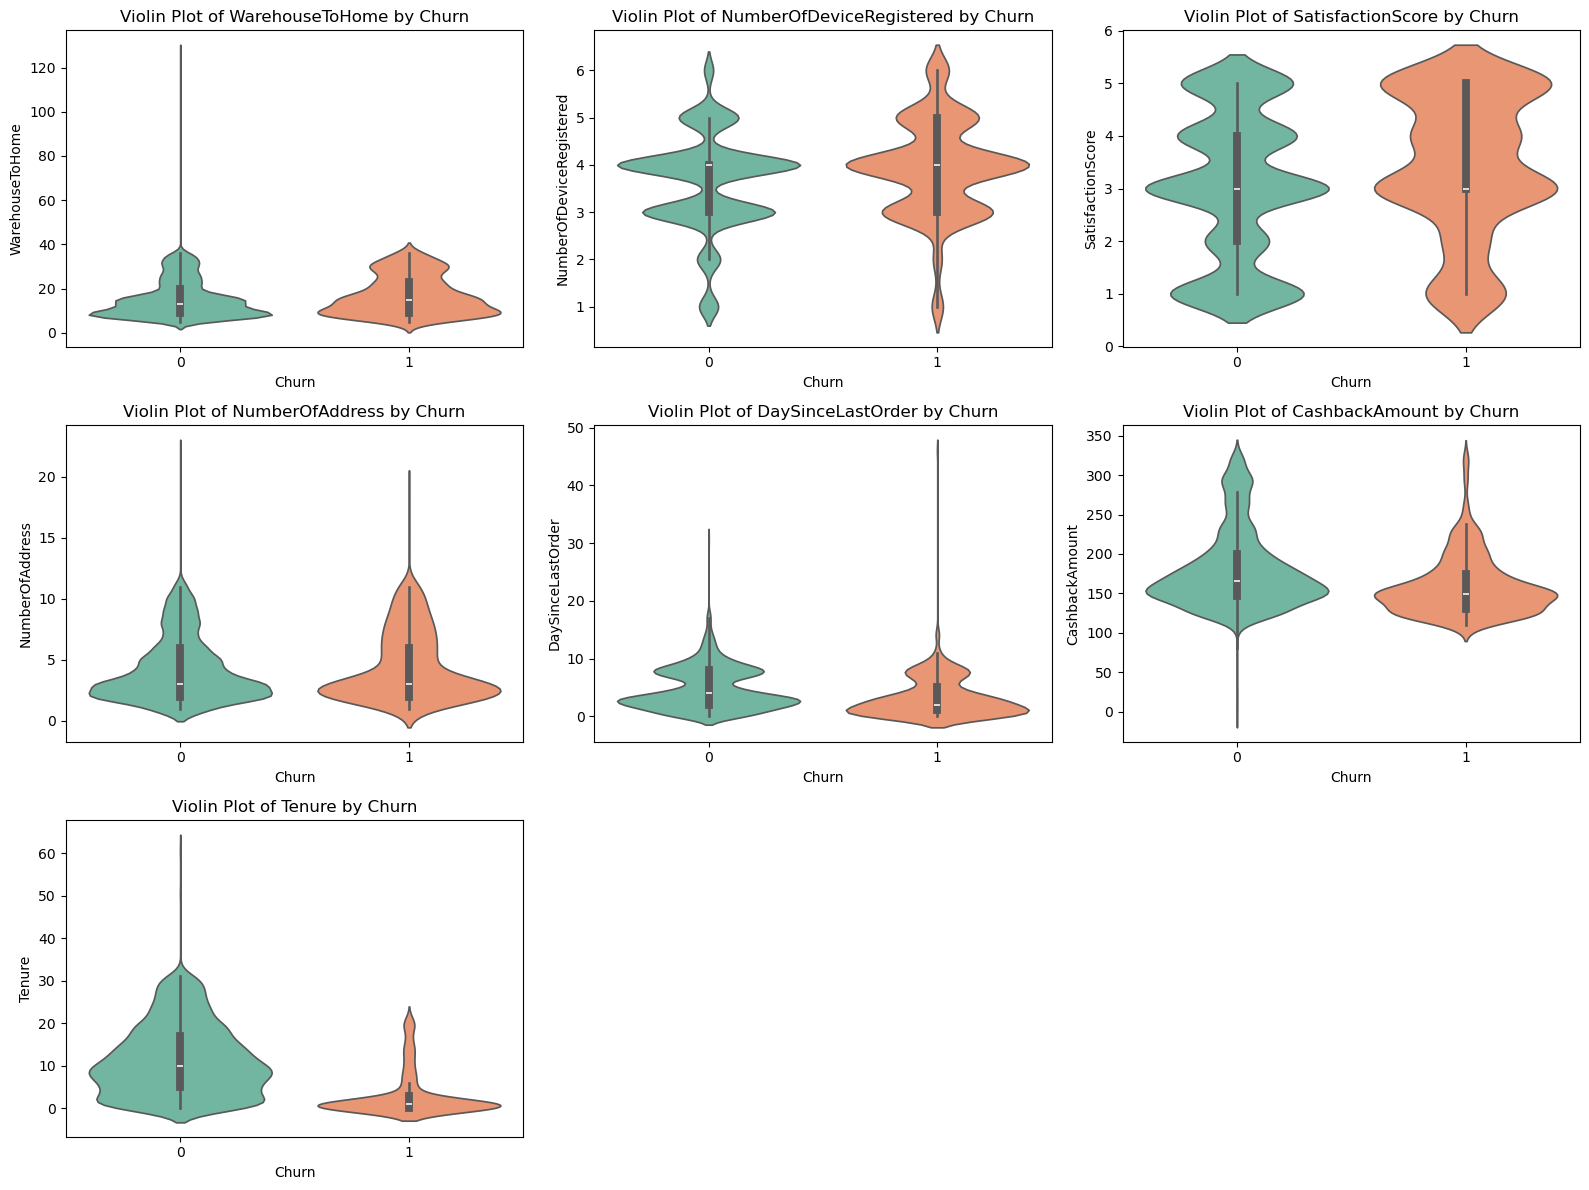

In [8]:
# Create a 3x2 grid for violin plots
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each numerical column and plot
for index, col in enumerate(numerical_columns_to_compare):
    sns.violinplot(data=df, x='Churn', y=col, palette='Set2', ax=axes[index])
    axes[index].set_title(f'Violin Plot of {col} by Churn', fontsize=12)
    axes[index].set_xlabel('Churn')
    axes[index].set_ylabel(col)

# Remove unused subplots (if any)
for i in range(len(numerical_columns_to_compare), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better readability
plt.tight_layout()
plt.show()

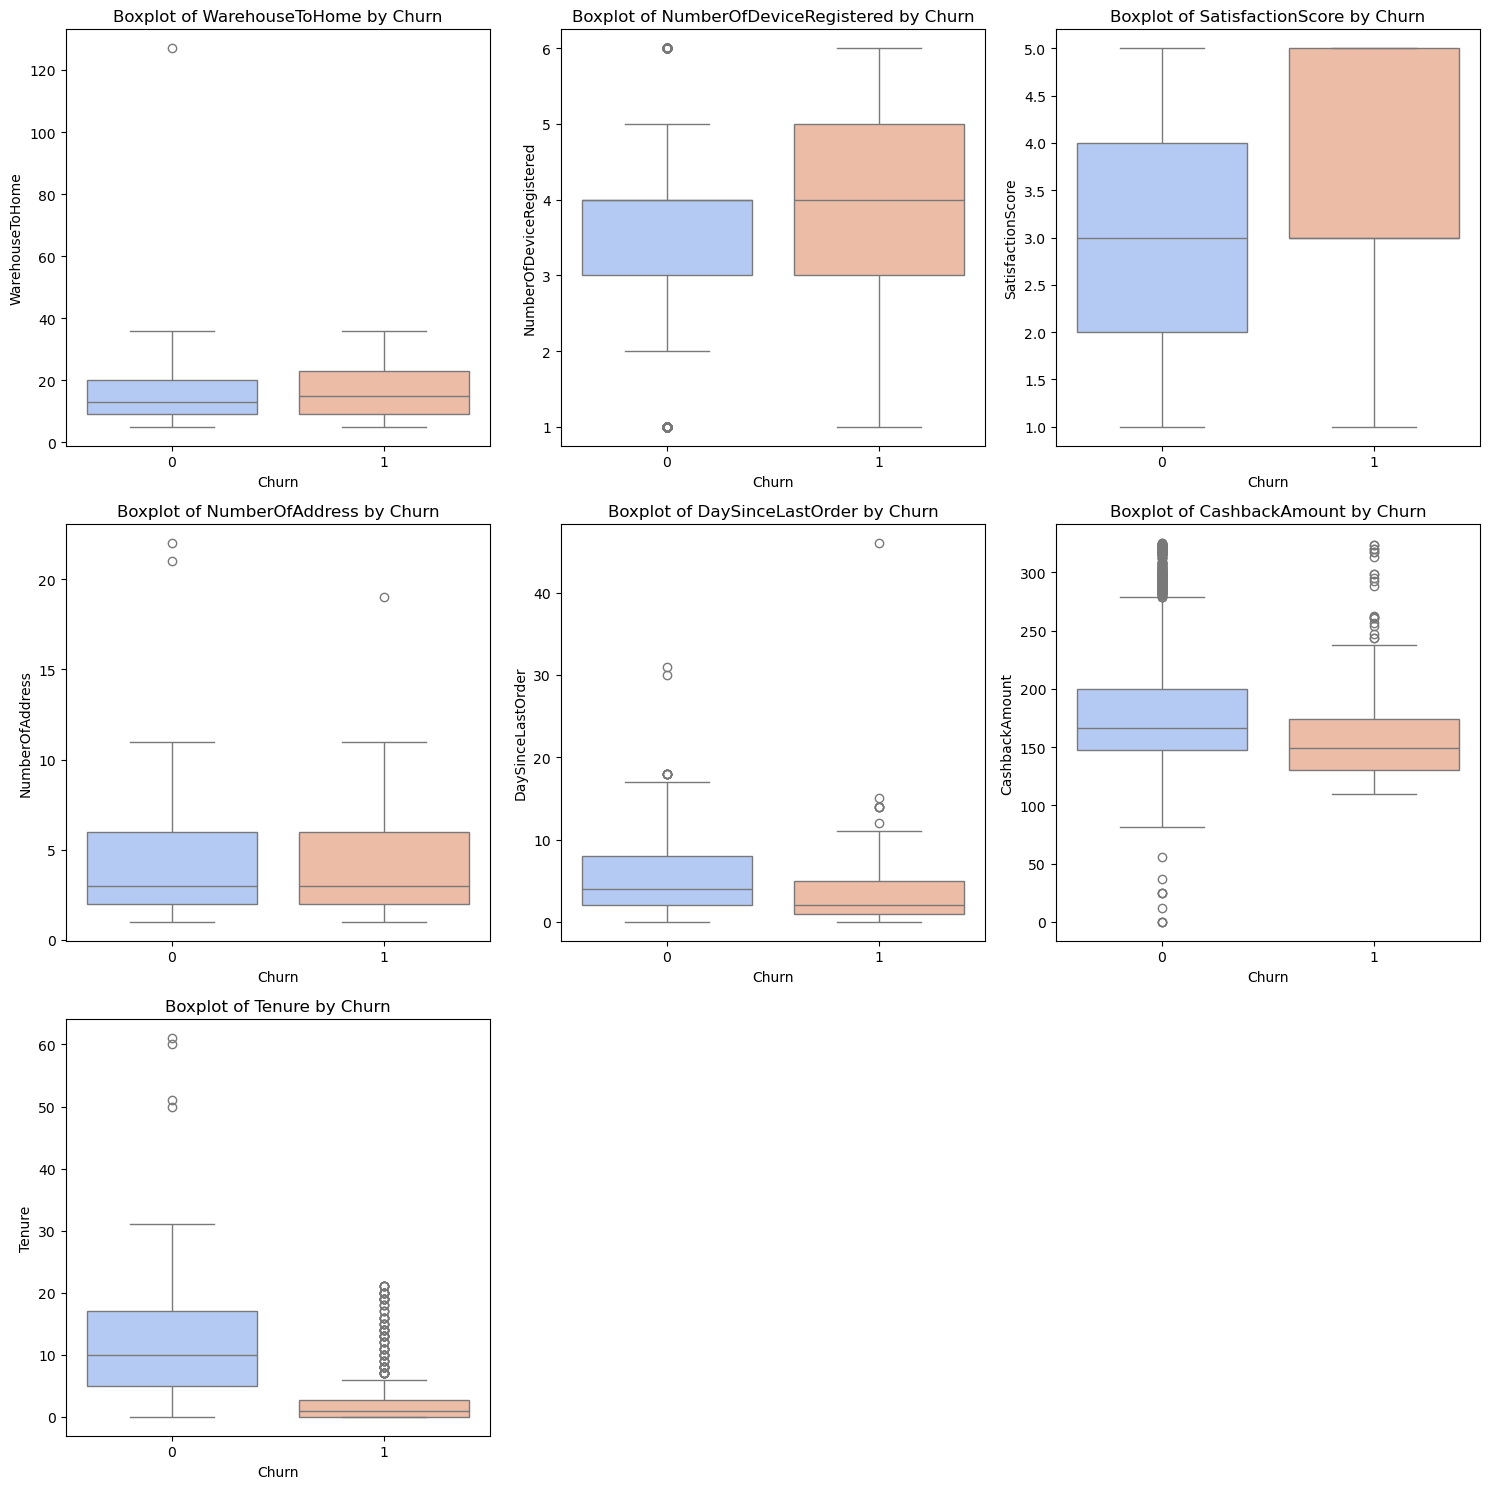

In [9]:
# Define the number of rows and columns for the subplot grid
n_cols = 3  # Number of columns in the grid
n_rows = -(-len(numerical_columns_to_compare) // n_cols)  # Calculate rows needed

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten to easily index each subplot

# Loop through numerical columns and create a boxplot for each
for index, col in enumerate(numerical_columns_to_compare):
    sns.boxplot(data=df, x='Churn', y=col, palette='coolwarm', ax=axes[index])
    axes[index].set_title(f'Boxplot of {col} by Churn', fontsize=12)
    axes[index].set_xlabel('Churn')
    axes[index].set_ylabel(col)

# Remove any unused subplots
for i in range(len(numerical_columns_to_compare), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

### Summary of Insights

1. **WarehouseToHome**:
   - Customers with higher `WarehouseToHome` distances tend to churn more frequently compared to those with shorter distances.

2. **NumberOfDeviceRegistered**:
   - Customers with a slightly higher number of registered devices are more likely to churn. However, the difference is not very significant.

3. **SatisfactionScore**:
   - Customers with lower satisfaction scores (closer to 1) are more likely to churn, suggesting dissatisfaction is a key factor.

4. **NumberOfAddress**:
   - Customers with a higher number of addresses associated with their account tend to churn more frequently. This might indicate a less stable or more transient customer base.

5. **DaySinceLastOrder**:
   - Customers who have placed orders more recently (lower `DaySinceLastOrder`) tend to churn less. Churned customers often exhibit higher values in this feature, indicating longer periods since their last order.

6. **CashbackAmount**:
   - Customers with lower cashback amounts tend to churn more often. Customers with higher cashback incentives appear more likely to remain loyal.

7. **Tenure**:
   - Customers with shorter tenures (closer to 0) tend to churn significantly more than those with longer tenures. This suggests that newer customers are at a higher risk of churn.

From the above, we can identify that customers with characteristics such as **shorter tenures, longer distances from warehouse, lower satisfaction scores, higher days since last order, and lower cashback amounts** are more likely to churn. 

We will continue to make a model to predict whether a customer will churn or not.

<hr style="border: 3px; height: 10px; background-color: #050A30;"> <!-- Colored line -->


## 3. Data Cleaning & Preprocessing


In [10]:
# remove duplicates
df.drop_duplicates(keep='first',inplace=True)

To ensure that each row represents a unique event or transaction, which aids in improving model training and prevents overfitting, the duplicates in this dataset were removed.

For future datasets, Ezora should consider adding a “Customer ID” or a unique identifier. This would help distinguish between true duplicates caused by logging errors and different customers who coincidentally share the same features, ensuring better data quality and more accurate insights

### Anomaly Data

PreferedOrderCat has Mobile dan Mobile Phone. Mobile will be changed into Mobile Phone as they are the same category.

In [11]:
df['PreferedOrderCat'].replace({'Mobile':'Mobile Phone'}, inplace=True)

In [12]:
# column names for check outliers
outliers = [
               'Tenure',
               'WarehouseToHome',
               'NumberOfDeviceRegistered',
               'SatisfactionScore',
               'NumberOfAddress',
               'DaySinceLastOrder',
               'CashbackAmount',
            ]

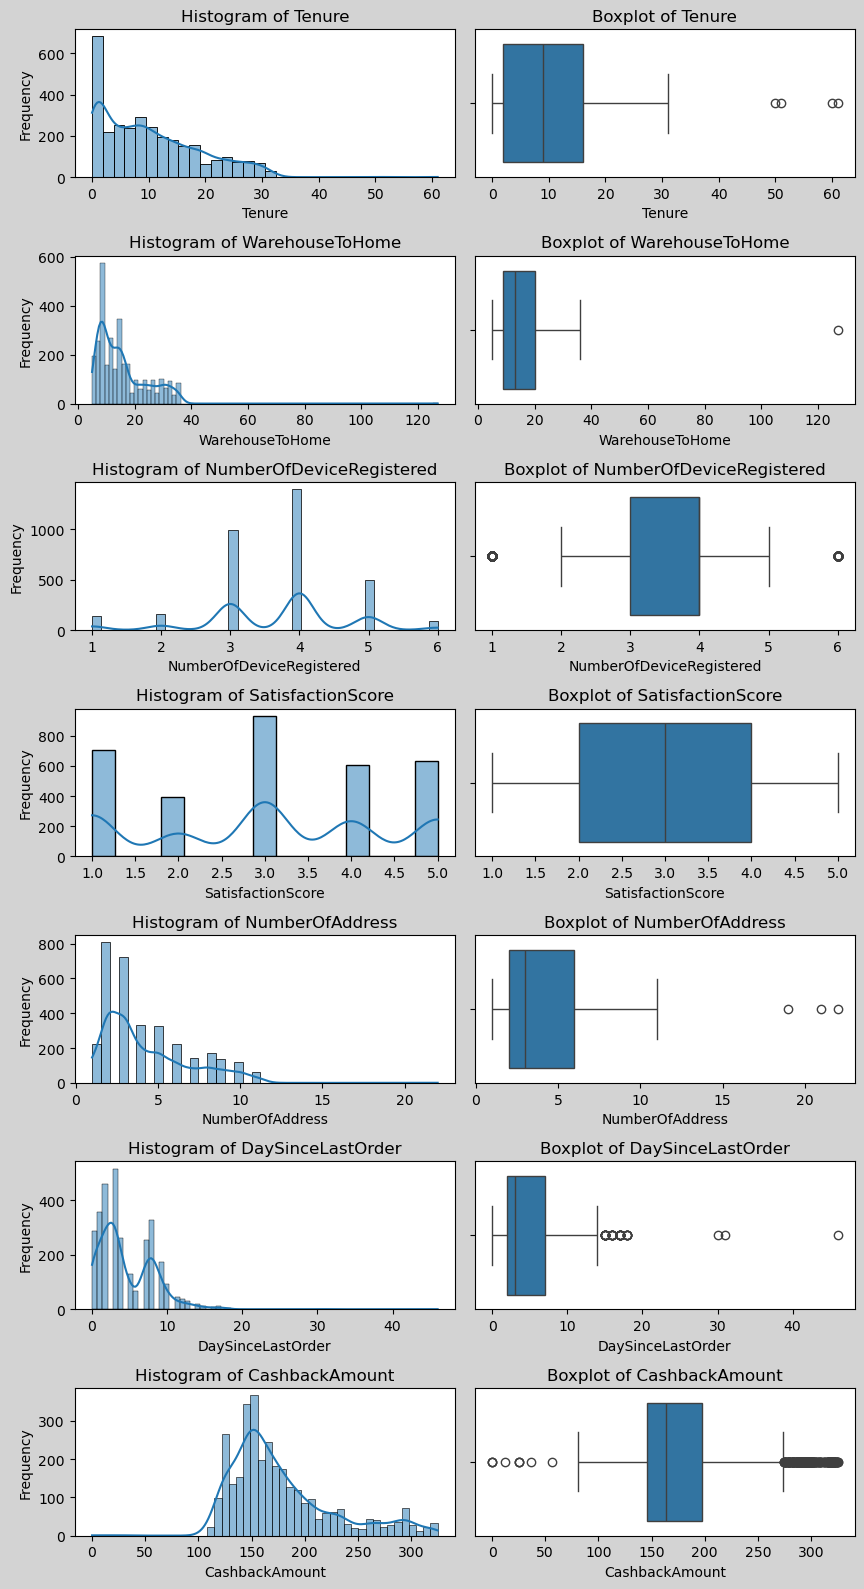

In [13]:
plt.figure(figsize=(len(outliers) * 1.25 , len(outliers) * 2 + 2))

for index, col in enumerate(outliers):
    # Histogram
    plt.subplot(len(outliers), 2, index * 2 + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(outliers), 2, index * 2 + 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

fig = plt.gcf()
fig.patch.set_facecolor('lightgrey')

plt.tight_layout()
plt.show()

<div style='text-align: justify'>
The e-commerce industry often has non-normal data distributions, The outliers will be able to make the model predict within that range. But we will check for extreme outliers, which will potentially make our model worse. 

### Outliers

In [14]:
def find_extreme_outliers_all_columns(df, target_column=None):
    outlier_dict = {}
    for column in df.columns:
        # Skip the target column if specified, and only process numeric columns
        if (target_column is None or column != target_column) and np.issubdtype(df[column].dtype, np.number):
            Q1 = np.percentile(df[column].dropna(), 25)  # Handle missing values
            Q3 = np.percentile(df[column].dropna(), 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            extreme_outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
            outlier_dict[column] = extreme_outliers.tolist()  # Store outliers as a list for readability
    return outlier_dict

# Example usage
extreme_outliers_all = find_extreme_outliers_all_columns(df, target_column='Churn')

# Print extreme outliers for each column
for col, outliers in extreme_outliers_all.items():
    print(f"Extreme Outliers in {col}: {outliers}")

Extreme Outliers in Tenure: [61.0, 60.0]
Extreme Outliers in WarehouseToHome: [127.0]
Extreme Outliers in NumberOfDeviceRegistered: []
Extreme Outliers in SatisfactionScore: []
Extreme Outliers in NumberOfAddress: [19, 22, 21]
Extreme Outliers in Complain: []
Extreme Outliers in DaySinceLastOrder: [30.0, 46.0, 31.0]
Extreme Outliers in CashbackAmount: []


In [15]:
def count_rows_with_outliers(df, outlier_dict):
    rows_with_outliers_per_column = {}
    for col, outliers in outlier_dict.items():
        if outliers:  # Only process columns with outliers
            count = df[df[col].isin(outliers)].shape[0]  # Count rows with outliers in this column
            rows_with_outliers_per_column[col] = count
    return rows_with_outliers_per_column

# Count rows with extreme outliers for each column
rows_with_outliers_count = count_rows_with_outliers(df, extreme_outliers_all)

# Print the result
for col, count in rows_with_outliers_count.items():
    print(f"Number of rows with extreme outliers in {col}: {count}")

Number of rows with extreme outliers in Tenure: 2
Number of rows with extreme outliers in WarehouseToHome: 1
Number of rows with extreme outliers in NumberOfAddress: 3
Number of rows with extreme outliers in DaySinceLastOrder: 3


In [16]:
# Remove extreme outliers in WarehouseToHome
df = df[~(df['WarehouseToHome'] == 127.0)]

# Remove extreme outliers in NumberOfAddress
df = df[~(df['NumberOfAddress'].isin([19, 22, 21]))]

# Remove extreme outliers in DaySinceLastOrder except for 30
df = df[~((df['DaySinceLastOrder'].isin([46.0, 31.0])) & (df['DaySinceLastOrder'] != 30.0))]

# Remove extreme outliers in Tenure except for 60
df = df[~((df['Tenure'] == 61.0) & (df['Tenure'] != 60.0))]

In [17]:
def find_extreme_outliers_all_columns(df, target_column=None):
    outlier_dict = {}
    for column in df.columns:
        # Skip the target column if specified, and only process numeric columns
        if (target_column is None or column != target_column) and np.issubdtype(df[column].dtype, np.number):
            Q1 = np.percentile(df[column].dropna(), 25)  # Handle missing values
            Q3 = np.percentile(df[column].dropna(), 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            extreme_outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
            outlier_dict[column] = extreme_outliers.tolist()  # Store outliers as a list for readability
    return outlier_dict

# Example usage
extreme_outliers_all = find_extreme_outliers_all_columns(df, target_column='Churn')

# Print extreme outliers for each column
for col, outliers in extreme_outliers_all.items():
    print(f"Extreme Outliers in {col}: {outliers}")

Extreme Outliers in Tenure: [60.0]
Extreme Outliers in WarehouseToHome: []
Extreme Outliers in NumberOfDeviceRegistered: []
Extreme Outliers in SatisfactionScore: []
Extreme Outliers in NumberOfAddress: []
Extreme Outliers in Complain: []
Extreme Outliers in DaySinceLastOrder: [30.0]
Extreme Outliers in CashbackAmount: []


The model will focus on tenure customers ≤ 60 months and recent order behaviors (≤ 30 days). Therefore, the following extreme outliers and irrelevant data will be removed:<br>

	•	Tenure > 60 months
	•	DaySinceLastOrder > 30 days

The extreme outliers are identified using the IQR formula with a multiplier of 3, which flags only the most extreme values while preserving the natural variability of e-commerce data. Removing Tenure > 60 and DaySinceLastOrder > 30 affects only 7 rows, a negligible sample, ensuring the model remains focused on actionable segments.

In [18]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), df[col].max(), df[col].min(),list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'max','min','uniqueSample'],
                     data=listItem)
dfDesc

dataFeatures dataType  null  nullPct  unique     max  \
0                     Tenure  float64   159     4.87      35    60.0   
1            WarehouseToHome  float64   135     4.14      32    36.0   
2   NumberOfDeviceRegistered    int64     0     0.00       6       6   
3           PreferedOrderCat   object     0     0.00       5  Others   
4          SatisfactionScore    int64     0     0.00       5       5   
5              MaritalStatus   object     0     0.00       3  Single   
6            NumberOfAddress    int64     0     0.00      11      11   
7                   Complain    int64     0     0.00       2       1   
8          DaySinceLastOrder  float64   181     5.55      20    30.0   
9             CashbackAmount  float64     0     0.00    2333  324.99   
10                     Churn    int64     0     0.00       2       1   

         min             uniqueSample  
0        0.0              [60.0, 5.0]  
1        5.0             [20.0, 27.0]  
2          1                   [2, 4]  
3    Fashion  [Fashion, Mobile Phone]  
4          1                   [2, 4]  
5   Divorced        [Single, Married]  
6          1                   [7, 3]  
7          0                   [1, 0]  
8        0.0              [18.0, 3.0]  
9        0.0         [294.06, 166.73]  
10         0                   [0, 1]

In [19]:
# Compute counts for each Churn category
churn_counts = df['Churn'].value_counts().reset_index()
churn_counts.columns = ['Churn', 'Count']

# Create a pie chart
fig = px.pie(churn_counts, names="Churn", 
             values="Count",  # Use the counts as values for the pie chart
             title="<b>" + "Churn Imbalance", 
             color="Churn", 
             color_discrete_sequence=['#BA1F33', '#3A506B'], 
             hole=0.4,  # To create a donut chart effect (optional)
             )

# Customize hover information to show the count
fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}'
)

# Customize the plot layout
fig.update_layout(
    title_font_size=30,
    title_font_color="black",
    title_x=0.5,
    hoverlabel_font_size=20,
    template="plotly",
)

# Show the plot
fig.show()

### Data Observations

- **Missing Values:**  
  The data shows a **Missing At Random (MAR)** pattern:  
  | Column             | Count | %   |
  |--------------------|-------|-----|
  | Tenure             | 193   | 4.9 |
  | WarehouseToHome    | 169   | 4.3 |
  | DaySinceLastOrder  | 213   | 5.4 |

	Leaving missing values in the dataset could lead to errors during training or biased predictions.
  KNN Imputer estimates missing values based on the similarity of features in the data. It considers neighboring data points, ensuring that the imputed values reflect the data’s natural structure. This will be implemented in the later step.

- **Duplicate Records:**  
  There are **671 duplicate rows**, representing **17%** of the total dataset.

- **Class Imbalance in Churn:**  
  The target column (`Churn`) exhibits significant imbalance:  
  | Value       | Count | %   |
  |-------------|-------|-----|
  | 0 (not churn)| 3262  | 82.9 |
  | 1 (churn)   | 673   | 17.1 |
  
  Imbalanced datasets can negatively impact machine learning model performance, as the model may focus on the majority class (not churn) while ignoring the minority class (churn). The model and step chosen below will address this problem.



In [20]:
# feature & target
X = df.drop(['Churn'], axis=1) # feature
y = df['Churn'] # target

In [21]:
categorical_features = X.columns[X.dtypes == object].tolist()
numeric_features = X.columns[X.dtypes != object].tolist()

In [22]:
# Pipelines for scaled and non-scaled models
scaling_pipeline = Pipeline([
    ('knn', KNNImputer(n_neighbors=10)),
    ('robust', RobustScaler()),  # Include scaling
])

non_scaling_pipeline= Pipeline([
    ('knn', KNNImputer(n_neighbors=10))  # Exclude scaling
])


In [23]:
# Transformer for scaling models
transformer_scaled = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), categorical_features),
    ('impute', scaling_pipeline, numeric_features),
], remainder='passthrough')

# Transformer for non-scaling models
transformer_non_scaled = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), categorical_features),
    ('impute', non_scaling_pipeline,  numeric_features),
], remainder='passthrough')


### Data Splitting

In [24]:
# ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

print('X_train shape:')
display(X_train.shape) 
print('')
print('X_test shape:')
display(X_test.shape)

X_train shape:


(2610, 10)


X_test shape:


(653, 10)

## 4. Model Selection


### Benchmark

In [25]:
#model with scalling
lr = LogisticRegression(random_state=rs)
knn = KNeighborsClassifier()
svc = SVC(random_state=rs)

#model without scalling
dt = DecisionTreeClassifier(random_state=rs)
rf = RandomForestClassifier(random_state=rs)
gbc = GradientBoostingClassifier(random_state=rs)
xgb = XGBClassifier(random_state=rs)
lgbm = LGBMClassifier(random_state=rs,verbose=-1) #to remove warnings


In [26]:
# Define Metric F2Score
f2_scorer = make_scorer(fbeta_score, beta=2)

In [27]:
# Function to evaluate models
def evaluate_model(model, X, y, transformer):
    pipeline = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    skfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs)
    scores = cross_val_score(pipeline, X, y, cv=skfold, scoring=f2_scorer)
    return scores.mean(), scores.std()

# Model dictionary
models = {
    'Logistic Regression': lr,
    'KNN': knn,
    'SVC': svc,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gbc,
    'XGBoost': xgb,
    'LightGBM': lgbm
}

# Evaluate scaling models
scaling_models = ['Logistic Regression', 'KNN', 'SVC']
results_scaled = {name: evaluate_model(model, X_train, y_train, transformer_scaled)
                  for name, model in models.items() if name in scaling_models}

# Evaluate non-scaling models
non_scaling_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
results_non_scaled = {name: evaluate_model(model, X_train, y_train, transformer_non_scaled)
                      for name, model in models.items() if name in non_scaling_models}


In [28]:
# Combine results
results_combined = {**results_scaled, **results_non_scaled}

# Create DataFrame
df_results = pd.DataFrame.from_dict(results_combined, orient='index', columns=['mean_f2_score', 'std_dev'])
df_results = df_results.sort_values('mean_f2_score', ascending=False)

df_results

mean_f2_score   std_dev
XGBoost                   0.680601  0.053229
LightGBM                  0.649982  0.059030
Decision Tree             0.643487  0.090501
Gradient Boosting         0.614590  0.038259
Random Forest             0.608889  0.055818
Logistic Regression       0.486835  0.037312
SVC                       0.443666  0.052372
KNN                       0.405779  0.084733

#### Addressing Class Imbalance with Penalized Models

The dataset has imbalanced classes, there are more customers who did not churn (negative class) than those who churned (positive class). To handle this imbalance, we use penalized models to give more importance to the minority class (churned customers) during training. 

For models that support `class_weight`, we apply this parameter to adjust the model's focus on both classes. However, for models that do not support `class_weight` (like KNN and Gradient Boosting Classifier), we cannot apply this directly.

For XGBoost, we use the `scale_pos_weight` parameter to handle class imbalance. This is calculated as:

**scale_pos_weight = number of negative samples / number of positive samples**

[references](https://xgboost.readthedocs.io/en/stable/parameter.html)

Using penalized models helps improve the detection of churned customers (positive class) without being biased toward the majority class. This ensures that the model gives more attention to the minority class while training.



In [29]:
# Count the number of samples in each class
negative_samples = (y_train == 0).sum()
positive_samples = (y_train == 1).sum()

# Calculate scale_pos_weight
scale_pos_weight = negative_samples / positive_samples

In [30]:
#model with scalling
lr_p = LogisticRegression(random_state=rs, class_weight="balanced")
knn_p = KNeighborsClassifier()
svc_p = SVC(random_state=rs, class_weight="balanced")

#model without scalling
dt_p = DecisionTreeClassifier(random_state=rs, class_weight="balanced")
rf_p = RandomForestClassifier(random_state=rs, class_weight="balanced")
gbc_p = GradientBoostingClassifier(random_state=rs)
xgb_p = XGBClassifier(random_state=rs, scale_pos_weight=scale_pos_weight)
lgbm_p = LGBMClassifier(random_state=rs,verbose=-1, class_weight="balanced")


In [31]:
# Function to evaluate models
def evaluate_model(model, X, y, transformer):
    pipeline = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    skfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs)
    scores = cross_val_score(pipeline, X, y, cv=skfold, scoring=f2_scorer)
    return scores.mean(), scores.std()

# Model dictionary
models_pen = {
    'Logistic Regression': lr_p,
    'KNN': knn_p,
    'SVC': svc_p,
    'Decision Tree': dt_p,
    'Random Forest': rf_p,
    'Gradient Boosting': gbc_p,
    'XGBoost': xgb_p,
    'LightGBM': lgbm_p
}

# Evaluate scaling models
scaling_models = ['Logistic Regression', 'KNN', 'SVC']
results_scaled_pen = {name: evaluate_model(model, X_train, y_train, transformer_scaled)
                  for name, model in models_pen.items() if name in scaling_models}

# Evaluate non-scaling models
non_scaling_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
results_non_scaled_pen = {name: evaluate_model(model, X_train, y_train, transformer_non_scaled)
                      for name, model in models_pen.items() if name in non_scaling_models}

In [32]:
# Combine results
results_penalized = {**results_scaled_pen, **results_non_scaled_pen}

# Create DataFrame
df_penalized = pd.DataFrame.from_dict(results_penalized, orient='index', columns=['mean_f2_score', 'std_dev'])
df_penalized = df_penalized.sort_values('mean_f2_score', ascending=False)

df_penalized

mean_f2_score   std_dev
LightGBM                  0.765123  0.037840
XGBoost                   0.731594  0.055187
SVC                       0.721472  0.025525
Logistic Regression       0.685118  0.036662
Decision Tree             0.640639  0.039230
Gradient Boosting         0.614590  0.038259
Random Forest             0.568064  0.035902
KNN                       0.405779  0.084733

In [33]:
best_model = lgbm_p # Example: Replace with the best model from your results
skfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs)

estimator = ImbPipeline([
    ('preprocess', transformer_non_scaled),  # Preprocessing step
    ('model', best_model)  # Use the best model (e.g., LightGBM or XGBoost)
])

# Step 2: Cross-validation on the training set (using F2 score)
train_score = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring=f2_scorer)
print(f"F2 Score (mean) on Training Set: {train_score.mean()}")
print(f"F2 Score (std) on Training Set: {train_score.std()}")


F2 Score (mean) on Training Set: 0.765122773933149
F2 Score (std) on Training Set: 0.037840340997604305


For further step, we will use light gbm as the best model resulted from model benchmarking.

**LightGBM (Light Gradient Boosting Machine)** is a is a powerful machine learning algorithm that uses tree based learning algorithms designed for speed and efficiency. Advantages og LightGBM : 	

•	Faster training speed and higher efficiency.

•	Lower memory usage.

•	Better accuracy.

•	Support for parallel, distributed, and GPU learning.

•	Ability to handle large-scale datasets.

LightGBM grows trees leaf-wise (best-first), which means it chooses the leaf with the maximum delta loss to grow. This approach achieves lower loss compared to level-wise algorithms for a fixed number of leaves. However, leaf-wise growth may cause overfitting on small datasets. To prevent this, the max_depth parameter can limit tree depth while still allowing leaf-wise growth.


[reference](https://lightgbm.readthedocs.io/en/stable/)

#### Feature Selection (RFE)

In [34]:
# # n_features_to_select = int(X_train.shape[1] * 0.8) 
# rfe_selector = RFE(estimator=best_model, n_features_to_select=12, step=1)

# # Define the full pipeline with preprocessing and RFE
# pipeline_rfe = ImbPipeline([
#     ('preprocess', transformer_non_scaled),  # Preprocessing step
#     ('rfe', rfe_selector),  # RFE feature selection
#     ('model', best_model)  # Model (LightGBM or any other classifier)
# ])

# # Step 4: Fit the pipeline with RFE
# pipeline_rfe.fit(X_train, y_train)

# # Get the selected features from RFE and map back to the original feature names
# selected_feature_indices = rfe_selector.support_
# selected_features = [f for i, f in enumerate(categorical_features + numeric_features) if selected_feature_indices[i]]

# print(f"Selected Features: {selected_features}")

**Implement the Selected Features**

In [35]:
# # Step 1: Select the features from training and test sets based on the RFE selection
# df_selected = df[selected_features]

# # feature & target
# X_selected = df_selected
# y_selected = df['Churn'] # target

# categorical_features = X_selected.columns[X_selected.dtypes == object].tolist()
# numeric_features = X_selected.columns[X_selected.dtypes != object].tolist()

In [36]:
# # ratio 80:20
# X_train_selected, X_test, y_train_selected, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=rs, stratify=y)

# print('X_train shape:')
# display(X_train_selected.shape) 
# print('')
# print('X_test shape:')
# display(X_test.shape)

In [37]:
# # Pipelines for scaled and non-scaled models
# scaling_pipeline = Pipeline([
#     ('knn', KNNImputer(n_neighbors=10)),
#     ('robust', RobustScaler()),  # Include scaling
# ])

# non_scaling_pipeline= Pipeline([
#     ('knn', KNNImputer(n_neighbors=10))  # Exclude scaling
# ])


In [38]:
# # Transformer for scaling models
# transformer_scaled = ColumnTransformer([
#     ('onehot', OneHotEncoder(drop='first'), categorical_features),
#     ('impute', scaling_pipeline, numeric_features),
# ], remainder='passthrough')

# # Transformer for non-scaling models
# transformer_non_scaled = ColumnTransformer([
#     ('onehot', OneHotEncoder(drop='first'), categorical_features),
#     ('impute', non_scaling_pipeline,  numeric_features),
# ], remainder='passthrough')


In [39]:
# best_model = lgbm_p # Example: Replace with the best model from your results
# skfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs)

# estimator = ImbPipeline([
#     ('preprocess', transformer_non_scaled),  # Preprocessing step
#     ('model', best_model)  # Use the best model (e.g., LightGBM or XGBoost)
# ])

# # Step 2: Cross-validation on the training set (using F2 score)
# train_score = cross_val_score(estimator, X_train_selected, y_train_selected, cv=skfold, scoring=f2_scorer)
# print(f"F2 Score (mean) on Training Set: {train_score.mean()}")
# print(f"F2 Score (std) on Training Set: {train_score.std()}")


In [40]:
# # feature & target
# X = df.drop(['Churn'], axis=1) # feature
# y = df['Churn'] # target

# categorical_features = X.columns[X.dtypes == object].tolist()
# numeric_features = X.columns[X.dtypes != object].tolist()

# # Pipelines for scaled and non-scaled models
# scaling_pipeline = Pipeline([
#     ('knn', KNNImputer(n_neighbors=10)),
#     ('robust', RobustScaler()),  # Include scaling
# ])

# non_scaling_pipeline= Pipeline([
#     ('knn', KNNImputer(n_neighbors=10))  # Exclude scaling
# ])

# # Transformer for scaling models
# transformer_scaled = ColumnTransformer([
#     ('onehot', OneHotEncoder(drop='first'), categorical_features),
#     ('impute', scaling_pipeline, numeric_features),
# ], remainder='passthrough')

# # Transformer for non-scaling models
# transformer_non_scaled = ColumnTransformer([
#     ('onehot', OneHotEncoder(drop='first'), categorical_features),
#     ('impute', non_scaling_pipeline,  numeric_features),
# ], remainder='passthrough')

In [41]:
# # ratio 80:20
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

# print('X_train shape:')
# display(X_train.shape) 
# print('')
# print('X_test shape:')
# display(X_test.shape)

Before Feature Selection : 

F2 Score (mean) on Training Set: 0.765122773933149<br>
F2 Score (std) on Training Set: 0.037840340997604305


After Feature Selection : 

F2 Score (mean) on Training Set: 0.7301029887081376
F2 Score (std) on Training Set: 0.05879851122139287

After applying feature selection using RFE, the model's performance did not improve. This indicates that the current features are already well-suited for the task and provide sufficient information for accurate predictions. Since the dataset has a limited number of features, removing any could reduce the model’s ability to learn effectively. Based on these results and domain knowledge, I will retain all features to ensure the model has access to the full range of data for learning.

#### Addressing Imbalance with Resampling Techniques

From several sampling techniques, I will use the top 2 f2 score from model benchmarking. 

Resampling Techniques: We’ll use five resampling methods:

•	SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic data points for the minority class.<br>
•	SMOTE-Tomek: A combination of SMOTE and Tomek Links (removes overlapping samples).<br>
•	RandomOverSampler: Randomly increases the minority class samples.<br>
•	RandomUnderSampler: Randomly reduces the majority class samples.<br>
•	CondensedNearestNeighbour (CNN): Condenses the majority class to keep only the samples necessary for classification.

In [42]:
# resampling methods
smote = SMOTE(random_state=rs)
smote_tomek = SMOTETomek(random_state=rs)
ros = RandomOverSampler(random_state=rs)
rus = RandomUnderSampler(random_state=rs)
cnn = CondensedNearestNeighbour(random_state=rs)

# list of resampling methods
resampler = [smote, smote_tomek, ros, rus, cnn, None]
resampler_names = ['SMOTE', 'SMOTE-Tomek', 'RandomOverSampler', 'RandomUnderSampler', 'CondensedNearestNeighbour',None]

# Model to compare in resampling
models_res = {
    'XGBoost': xgb_p,
    'LightGBM': lgbm_p
}

In [43]:
results = []

# Loop through models and resampling methods
for model_name, model in models_res.items():
    for k in resampler:
        skfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs)

        # Define pipeline based on whether resampling is used
        if k is None:
            estimator = ImbPipeline([
                ('preprocess', transformer_non_scaled),  # Preprocessing step
                ('model', model)  # Model (LightGBM or XGBoost)
            ])
        else:
            estimator = ImbPipeline([
                ('preprocess', transformer_non_scaled),  # Preprocessing step
                ('resampler', k),  # Resampling step
                ('model', model)  # Model (LightGBM or XGBoost)
            ])

        # Perform cross-validation
        model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring=f2_scorer)

        # Store results
        results.append({
            'model': f"{model_name}_{k.__class__.__name__}" if k else f"{model_name}_no_resampling",
            'mean_f2_score_train': model_cv.mean(),
            'sdev': model_cv.std()
        })


# Create DataFrame to view results
df_resample_train = pd.DataFrame(results).sort_values(by='mean_f2_score_train', ascending=False)

df_resample_train


model  mean_f2_score_train      sdev
11              LightGBM_no_resampling             0.765123  0.037840
3           XGBoost_RandomUnderSampler             0.756631  0.034160
4    XGBoost_CondensedNearestNeighbour             0.755997  0.038921
1                   XGBoost_SMOTETomek             0.754709  0.060221
8           LightGBM_RandomOverSampler             0.753773  0.051288
2            XGBoost_RandomOverSampler             0.753376  0.067199
10  LightGBM_CondensedNearestNeighbour             0.751620  0.047838
9          LightGBM_RandomUnderSampler             0.750475  0.040650
0                        XGBoost_SMOTE             0.742110  0.057848
5                XGBoost_no_resampling             0.731594  0.055187
6                       LightGBM_SMOTE             0.689147  0.059658
7                  LightGBM_SMOTETomek             0.677493  0.060166

The **LightGMB with no resampling** has the highest f2 score. For further tuning, LightGMB will be used as the current best model because it has the best mean F2 score, and the slight higher (than XGBoost RUS) in standard deviation is negligible.


In [44]:
best_model = lgbm_p # Example: Replace with the best model from your results
best_resampler = None  # Example: Replace with the best resampler from your results (e.g., smote, ros, etc.)

best_estimator = ImbPipeline([
    ('preprocess', transformer_non_scaled),  # Preprocessing step
    ('resampler', best_resampler),  # Resampling step
    ('model', best_model)  # Use the best model (e.g., LightGBM or XGBoost)
])

# Step 2: Cross-validation on the training set (using F2 score)
train_score = cross_val_score(best_estimator, X_train, y_train, cv=skfold, scoring=f2_scorer)
print(f"F2 Score (mean) on Training Set: {round(train_score.mean(),2)}")
print(f"F2 Score (std) on Training Set: {round(train_score.std(),2)}")


F2 Score (mean) on Training Set: 0.77
F2 Score (std) on Training Set: 0.04


In [45]:
final_model = best_estimator.fit(X_train, y_train)

# Step 4: Predict on the test set
y_pred_test = final_model.predict(X_test)

# Step 5: Calculate F2 score on the test set
f2_score_test = fbeta_score(y_test, y_pred_test, beta=2)
print(f"F2 Score on Test Set:{round(f2_score_test,2)}")

F2 Score on Test Set:0.81


In [46]:
report = classification_report(y_test, y_pred_test)

# classification report
print('Classification Report: \n', report)


Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       547
           1       0.75      0.83      0.79       106

    accuracy                           0.93       653
   macro avg       0.86      0.89      0.87       653
weighted avg       0.93      0.93      0.93       653



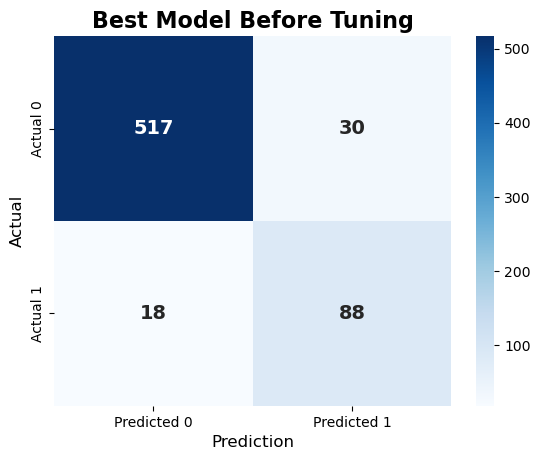

In [47]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot the heatmap directly
sns.heatmap(cm, annot=True, fmt='.0f',
            cmap='Blues', annot_kws={'size': 14, 'weight': 'bold'},
            xticklabels=['Predicted 0', 'Predicted 1'],  # Customize x-axis labels
            yticklabels=['Actual 0', 'Actual 1'])       # Customize y-axis labels

# Add axis labels and title
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Best Model Before Tuning', size=16, fontweight='bold')

plt.show()

#### Hyperparameter Tuning

To optimize the performance of the model, the hyperparameter tuning applied to find the best combination of parameters. The parameters tuned are:

- **`n_estimators`**: The number of trees in the model. A higher number can improve accuracy but may increase computation time.
- **`learning_rate`**: Controls how much the model adjusts at each step. A smaller value ensures stable training and reduces the risk of overfitting.
- **`max_depth`**: Limits the depth of each tree to prevent overfitting while capturing complex patterns.
- **`num_leaves`**: The maximum number of leaves in each tree. A smaller number reduces complexity and helps generalization.

These parameters were tuned using randomized search to efficiently explore a range of values and identify the best configuration for the task.

[references](https://lightgbm.readthedocs.io/en/v3.3.2/Parameters-Tuning.html)

In [48]:
hyperparam_space1 = {
    'model__n_estimators': randint(500, 1000),  # Focus on moderately high number of trees
    'model__learning_rate': uniform(0.01, 0.05),  # Slower learning rates for stable training
    'model__max_depth': randint(10, 20),  # Deeper trees for more complex splits
    'model__num_leaves': randint(10, 50),  # Smaller number of leaves
}

# Perform Random Search to search the hyperparameter space
random_search = RandomizedSearchCV(
    estimator=best_estimator,
    param_distributions=hyperparam_space1,
    n_iter=100,
    cv=5,
    random_state=rs,
    scoring=f2_scorer,
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)
# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the best F2 score found by GridSearchCV
print(f"Best Parameters: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__learning_rate': 0.013252579649263976, 'model__max_depth': 13, 'model__n_estimators': 588, 'model__num_leaves': 23}


Best Parameters: {'model__learning_rate': 0.013252579649263976, 'model__max_depth': 13, 'model__n_estimators': 588, 'model__num_leaves': 23}<br>

In [49]:
tuned_model = random_search.best_estimator_

In [50]:
# tuned_estimator = ImbPipeline([
#     ('preprocess', transformer_non_scaled),  # Preprocessing step
#     ('model', tuned_model)  # Use the tuned LightGBM model
# ])

In [51]:
# Cross-validation with tuned model
tuned_train_score = cross_val_score(tuned_model, X_train, y_train, cv=skfold, scoring=f2_scorer)

# Print cross-validation F2 scores
print(f"Tuned F2 Score (mean) on Training Set: {round(tuned_train_score.mean(),2)}")
print(f"Tuned F2 Score (std) on Training Set: {round(tuned_train_score.std(),2)}")

final_tuned_model = tuned_model.fit(X_train, y_train)

Tuned F2 Score (mean) on Training Set: 0.76
Tuned F2 Score (std) on Training Set: 0.05


In [52]:
y_pred_tuned_test = final_tuned_model.predict(X_test)

# Calculate F2 score on the test set
f2_score_tuned_test = fbeta_score(y_test, y_pred_tuned_test, beta=2)

# Print the test F2 score
print(f"Tuned F2 Score on Test Set: {round(f2_score_tuned_test,2)}")

Tuned F2 Score on Test Set: 0.84


In [53]:
report_tuned = classification_report(y_test, y_pred_tuned_test)

# classification report
print('Classification Report: \n', report_tuned)


Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       547
           1       0.70      0.88      0.78       106

    accuracy                           0.92       653
   macro avg       0.84      0.90      0.87       653
weighted avg       0.93      0.92      0.92       653



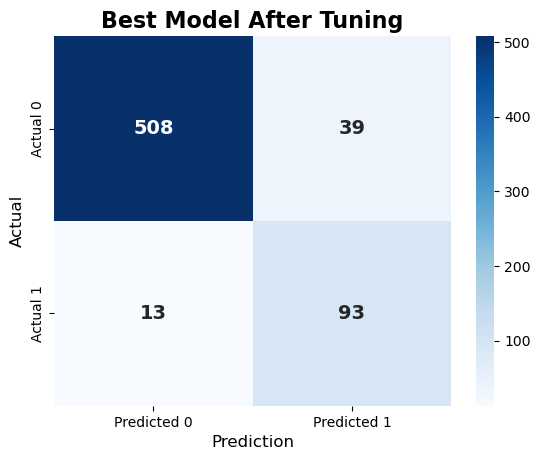

In [54]:
# Generate confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned_test)

# Plot the heatmap directly
sns.heatmap(cm_tuned, annot=True, fmt='.0f',
            cmap='Blues', annot_kws={'size': 14, 'weight': 'bold'},
            xticklabels=['Predicted 0', 'Predicted 1'],  # Customize x-axis labels
            yticklabels=['Actual 0', 'Actual 1'])       # Customize y-axis labels

# Add axis labels and title
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Best Model After Tuning', size=16, fontweight='bold')

# Adjust layout and display
plt.show()

#### Compare Before and After Tuning

In [55]:
print('Classification Report (Before Tuning): \n', report)

print('Classification Report (After Tuning): \n', report_tuned)


Classification Report (Before Tuning): 
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       547
           1       0.75      0.83      0.79       106

    accuracy                           0.93       653
   macro avg       0.86      0.89      0.87       653
weighted avg       0.93      0.93      0.93       653

Classification Report (After Tuning): 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       547
           1       0.70      0.88      0.78       106

    accuracy                           0.92       653
   macro avg       0.84      0.90      0.87       653
weighted avg       0.93      0.92      0.92       653



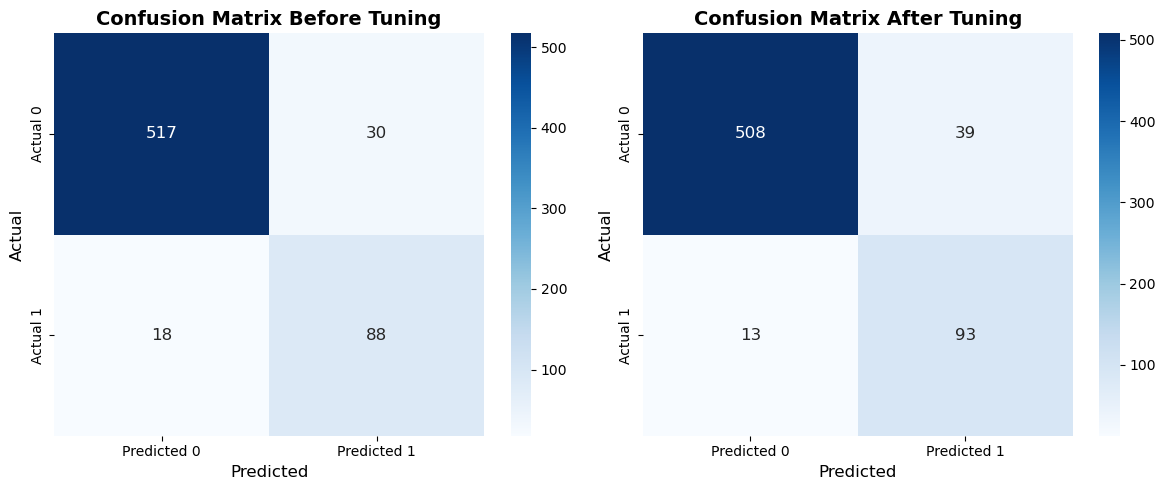

In [56]:
# Generate confusion matrices
cm_before = confusion_matrix(y_test, y_pred_test)
cm_after = confusion_matrix(y_test, y_pred_tuned_test)

# Create a figure for side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Heatmap before tuning
sns.heatmap(cm_before, annot=True, fmt='.0f', cmap='Blues', annot_kws={'size': 12}, ax=axes[0])
axes[0].set_title("Confusion Matrix Before Tuning", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Predicted", fontsize=12)
axes[0].set_ylabel("Actual", fontsize=12)
axes[0].set_xticklabels(['Predicted 0', 'Predicted 1'])
axes[0].set_yticklabels(['Actual 0', 'Actual 1'])

# Right: Heatmap after tuning
sns.heatmap(cm_after, annot=True, fmt='.0f', cmap='Blues', annot_kws={'size': 12}, ax=axes[1])
axes[1].set_title("Confusion Matrix After Tuning", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Predicted", fontsize=12)
axes[1].set_ylabel("Actual", fontsize=12)
axes[1].set_xticklabels(['Predicted 0', 'Predicted 1'])
axes[1].set_yticklabels(['Actual 0', 'Actual 1'])

# Adjust layout
plt.tight_layout()
plt.show()

The results indicate that the tuned model offers a better performance for our objective in minimizing false negatives (FN).

- From the confusion matrix we can see that the false negatives decreased from 18 (before tuning) to 13 (after tuning).

- From the F2 score increased from 0.8118 (before tuning) to 0.8363 (after tuning) on the test set.

- The precision for class 1 dropped slightly from 0.75 to 0.70, but this is an acceptable trade-off given the goal of minimizing false negatives.

#### Feature Importance / SHAP

In [57]:
# Fit the transformer to the training data
transformer_non_scaled.fit(X_train)

# Get feature names after transformation
feature_names = transformer_non_scaled.get_feature_names_out()

In [58]:
tuned_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus']),
                                                 ('impute',
                                                  Pipeline(steps=[('knn',
                                                                   KNNImputer(n_neighbors=10))]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount'])])),
                ('resampler', None),
                ('model',
                 LGBMClassifier(class_weight='balanced',
                                learning_rate=0.013252579649263976,
                                max_depth=13, n_estimators=588, num_leaves=23,
                                random_state=42, verbose=-1))])

In [59]:
print(tuned_model.named_steps)

{'preprocess': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(drop='first'),
                                 ['PreferedOrderCat', 'MaritalStatus']),
                                ('impute',
                                 Pipeline(steps=[('knn',
                                                  KNNImputer(n_neighbors=10))]),
                                 ['Tenure', 'WarehouseToHome',
                                  'NumberOfDeviceRegistered',
                                  'SatisfactionScore', 'NumberOfAddress',
                                  'Complain', 'DaySinceLastOrder',
                                  'CashbackAmount'])]), 'resampler': None, 'model': LGBMClassifier(class_weight='balanced', learning_rate=0.013252579649263976,
               max_depth=13, n_estimators=588, num_leaves=23, random_state=42,
               verbose=-1)}


In [60]:
feature_importances = lgbm_p.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df['Importance (%)'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum() * 100

In [61]:
feature_importance_df

Feature  Importance  Importance (%)
13                       impute__CashbackAmount         674       22.466667
7                       impute__WarehouseToHome         511       17.033333
6                                impute__Tenure         413       13.766667
12                    impute__DaySinceLastOrder         359       11.966667
10                      impute__NumberOfAddress         305       10.166667
9                     impute__SatisfactionScore         222        7.400000
8              impute__NumberOfDeviceRegistered         157        5.233333
11                             impute__Complain         122        4.066667
5                  onehot__MaritalStatus_Single          73        2.433333
1   onehot__PreferedOrderCat_Laptop & Accessory          62        2.066667
4                 onehot__MaritalStatus_Married          58        1.933333
2         onehot__PreferedOrderCat_Mobile Phone          29        0.966667
3               onehot__PreferedOrderCat_Others          11        0.366667
0              onehot__PreferedOrderCat_Grocery           4        0.133333

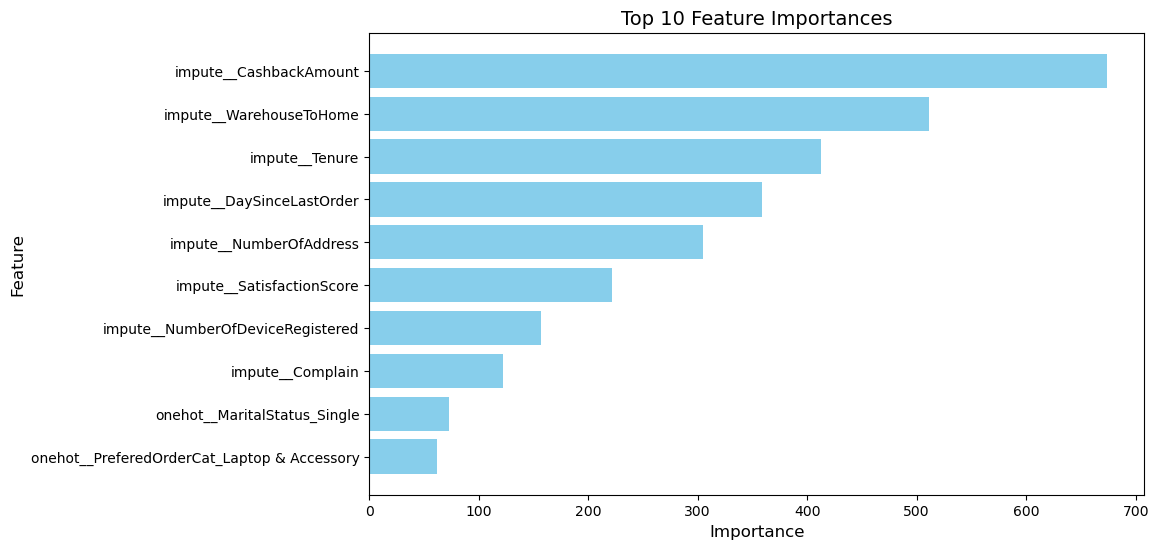

In [62]:
# Sort feature importance by descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['Feature'][:10],  # Top 10 feature names
    feature_importance_df['Importance'][:10],  # Top 10 importance scores
    color='skyblue'
)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importances', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance on top
plt.show()

Feature importance as shown in the model output is calculated based on how much each feature contributes to reducing the split criteria during tree construction. CashbackAmount is the top feature because it likely had the highest impact on the tree’s splits during training.

SHAP values are a common way of getting a consistent and objective explanation of how each feature impacts our model's prediction.

SHAP values are based on game theory and assign an importance value to each feature in a model. Features with positive SHAP values positively impact the prediction, while those with negative values have a negative impact. The magnitude is a measure of how strong the effect is.

In this section, we will calculate SHAP values and visualize feature importance.

In [63]:
# Extract components from the pipeline
preprocessor = tuned_model.named_steps['preprocess']
model = tuned_model.named_steps['model']

X_train_transformed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

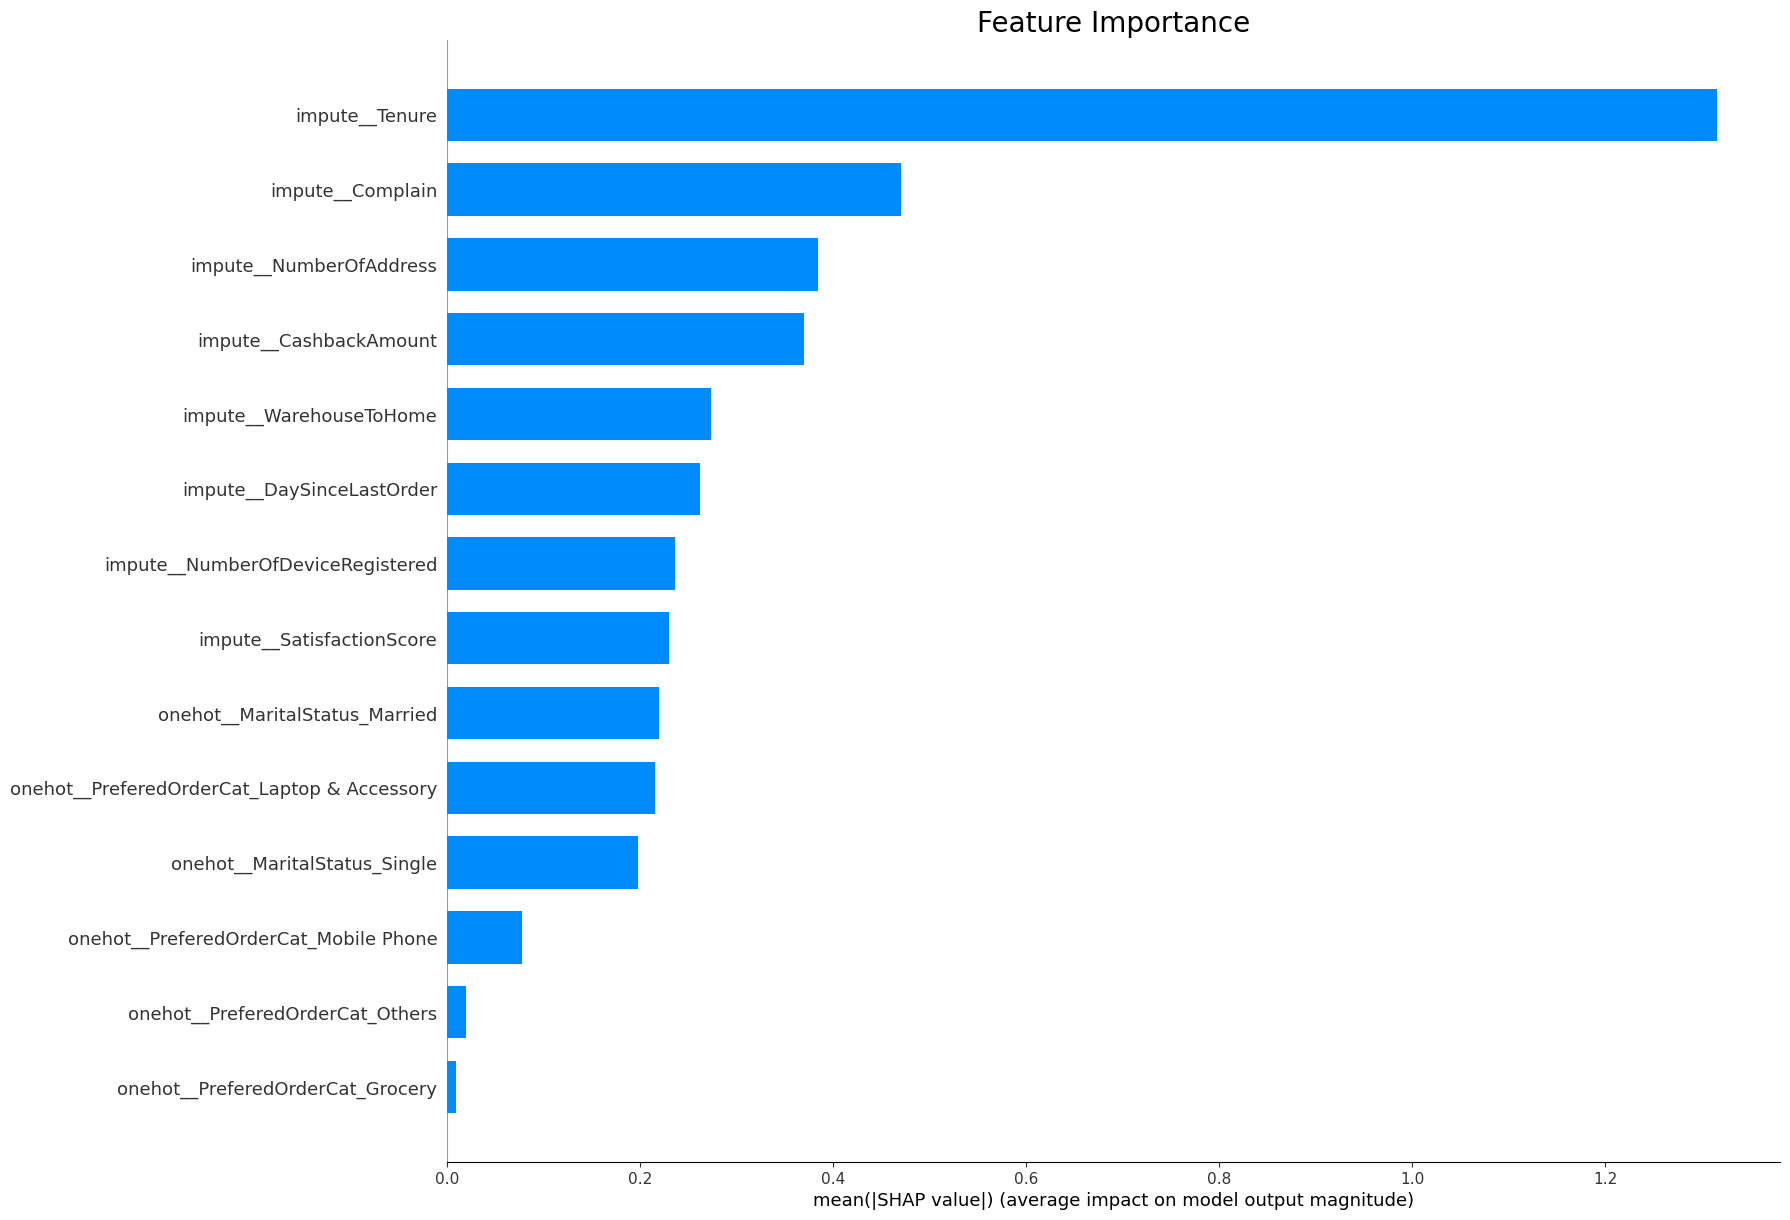

In [64]:
plt.figure(figsize=(80, 60))

# feature importance bar plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names,
                  title='Feature Importance', plot_type='bar', show=False, plot_size=(18, 12))
plt.title('Feature Importance', fontsize=20)
plt.show()

The mean SHAP value reflects the average contribution of a feature to the model’s predictions across all samples. A higher mean SHAP value indicates that the feature has a greater impact on the model’s predictions and features with lower mean SHAP values contribute less to the model’s decision-making.

To see whether a feature’s contribution is positive or negative for specific predictions, let us see the SHAP summary plots below.

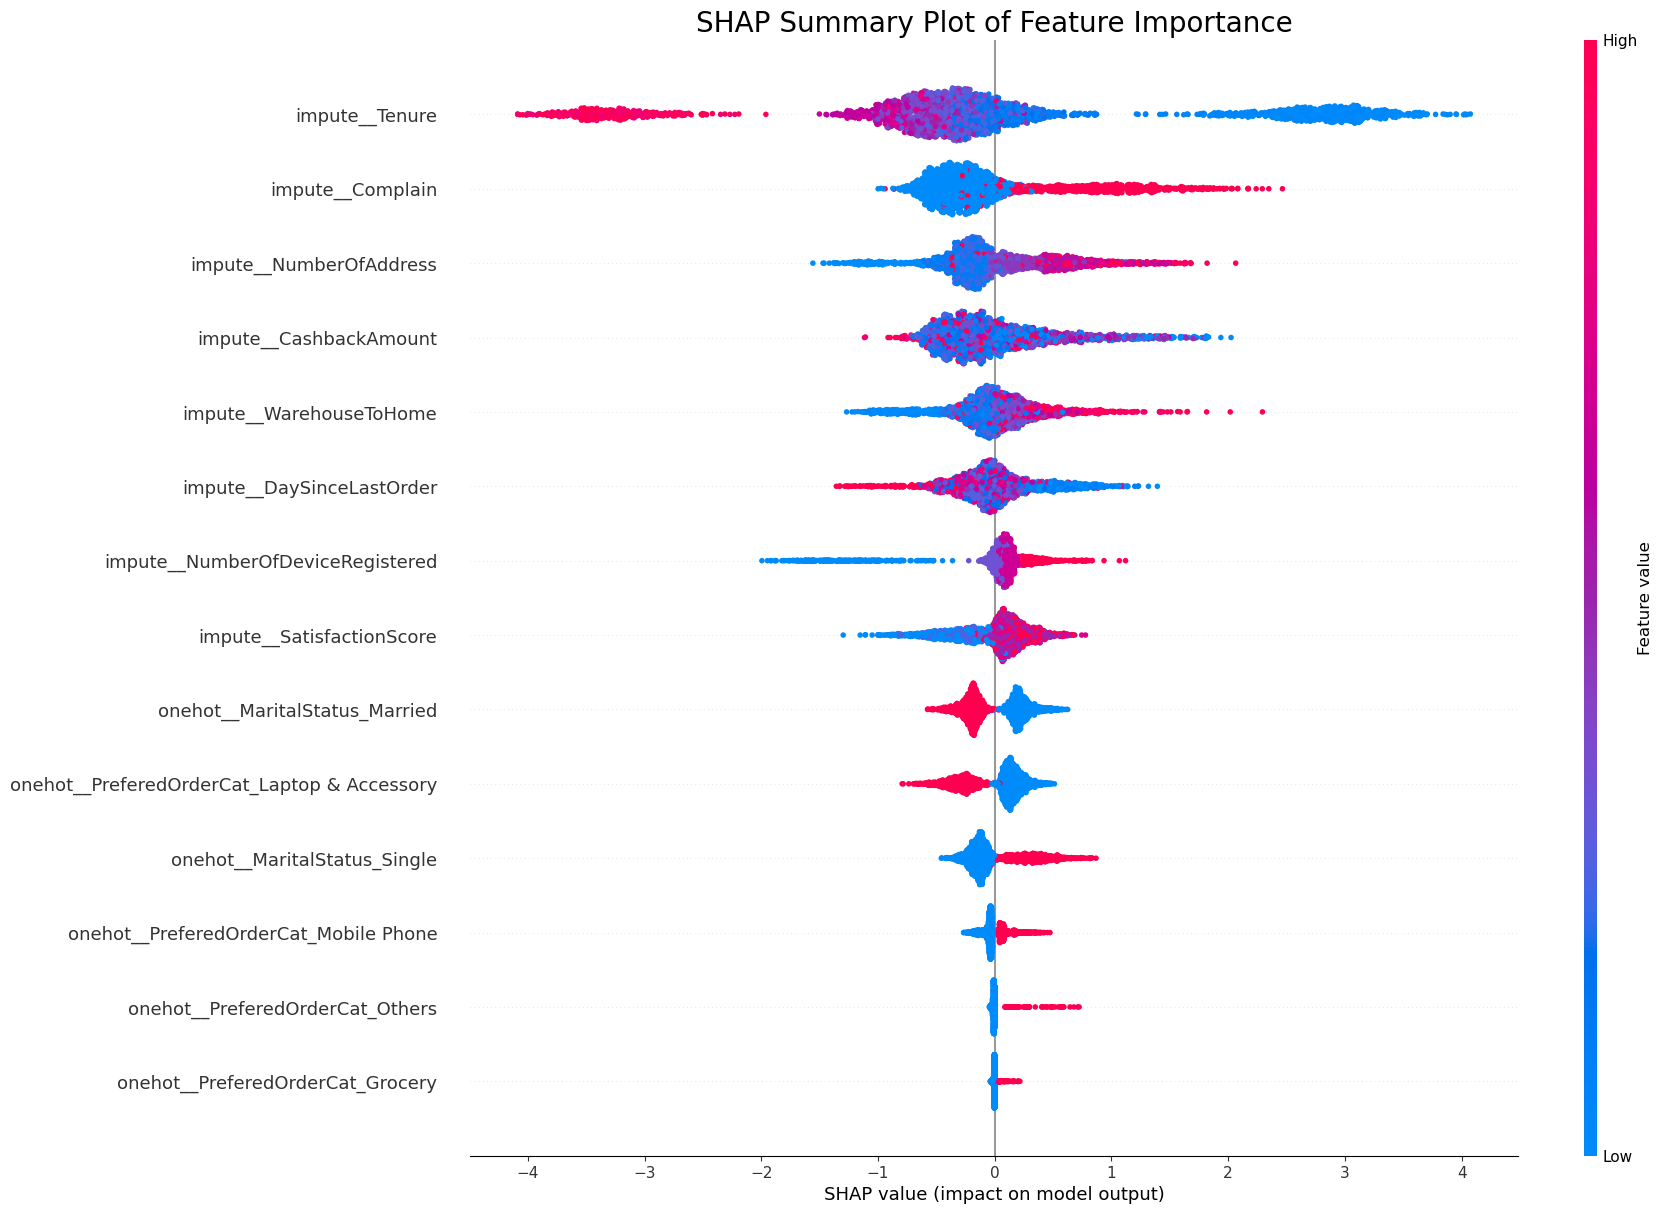

In [65]:
plt.figure(figsize=(100, 50))

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, show=False, plot_size=(18, 12))
plt.title('SHAP Summary Plot of Feature Importance', fontsize=20)

# show plot
plt.show()

•	Positive SHAP values (pushing predictions toward class 1).<br>
•	Negative SHAP values (pushing predictions away from class 1, toward class 0).

1. Most Important Features Driving Churn

- Tenure:	Customers with longer tenure are less likely to churn. On the flip side, new customers are more at risk.

- Complaints: If a customer complains, it strongly increases the chances they’ll churn.

- Number of Addresses: Customers with multiple addresses are more likely to churn. It might signal that they’re unsettled or not committed to the platform.

- Cashback Amount: Higher cashback rewards lower the chances of churn.


2. Less Important Features but Worth Watching

- Distance Between Warehouse and Home: Customers living farther from the warehouse are slightly more likely to churn, possibly due to delivery delays.

- Days Since Last Order: If someone hasn’t ordered in a while, they’re at risk of churning.

- Number of Devices Registered: Customers with more registered devices are slightly less likely to churn, as they seem more engaged.

- Satisfaction Score : Customers with higher satisfaction score are more likely to stay using our platform

3. Patterns in Customer Segments

- Marital Status: Married customers are slightly more likely to stay compared to single or divorced customers.

- Preferred Product Categories: Customers interested in “Laptop & Accessory” seem less likely to churn, while those preferring “Mobile Phones” are slightly more likely to leave. This might indicate our platform are not competitive in Mobile Phones sector compare to competitor. 


4. Recommendation

- Focus on onboarding new customers and making their early experience great. A welcome program or exclusive discounts for new users could help.
- Complaints need to be taken seriously. A quick and efficient resolution system or proactive follow-ups for unhappy customers can make a difference.
- Monitor customers with frequent address changes and consider offering loyalty perks to keep them engaged.
- Offer cashback promotions strategically, especially to customers showing signs of leaving, like reduced activity or complaints.
- Optimize delivery logistics or offer free/faster delivery for customers in remote locations.
- Send reminders, personalized offers, or even discounts to encourage them to place another order.
-  A competitor analysis in the Mobile Phones category could help identify gaps and opportunities for improvement.
- Tailor campaigns for different life stages. For example, promote family-oriented products or services for married customers.
- Highlight loyalty benefits or run targeted campaigns for higher-risk categories, like mobile phones.


In [66]:
#SAVING MODEL

save_model = tuned_model.fit(X_train, y_train)
file_name = 'ecommerce_churn_model.sav'
pickle.dump(save_model, open(file_name, 'wb'))

## 5. Conclusion and Recommendation


### **Conclusion**

Ezora is facing financial challenges due to budget restriction and rising customer acquisition costs (INR 1200–1500 per new customer) combines with a high monthly churn rate of 17%. These factors make retention more critical than ever. The developed churn prediction model provides a **data-driven solution** to prioritize high-risk customers, enabling the marketing team to allocate resources more efficiently while improving customer retention.

1. **Focused Retention Campaigns**:
   - The churn prediction model helps **identify customers most likely to churn**, allowing Ezora to shift from a blanket marketing approach to targeted retention efforts.
   - This ensures marketing efforts are directed toward the right customers.

2. **Improved Marketing Efficiency**:
   - By focusing on customers flagged by the model, Ezora can **reduce unnecessary spending** on retention campaigns for customers who are unlikely to churn, saving valuable resources.

3. **Evaluation Model**:
   - The model focuses on a **high F2 score**, prioritizing recall to identify the majority of churn-risk customers while balancing precision to minimize false positives.
   - This model performance must be validated through **A/B testing** campaign, comparing churn rates between campaign-targeted customers and a control group. Evaluation must be done thoroughly before going through the full production step.

4. **Business Impact**:
   - Transitioning to a data-driven retention strategy using customer prediction can reduce churn, lower overall marketing costs, ensuring sustainability in a competitive e-commerce market.


In [67]:
cm_after = confusion_matrix(y_test, y_pred_tuned_test)

print('Classification Report (After Tuning): \n', report_tuned)
print(f"Tuned F2 Score on Test Set: {round(f2_score_tuned_test,2)}")

Classification Report (After Tuning): 
               precision    recall  f1-score   support

           0       0.98      0.93      0.95       547
           1       0.70      0.88      0.78       106

    accuracy                           0.92       653
   macro avg       0.84      0.90      0.87       653
weighted avg       0.93      0.92      0.92       653

Tuned F2 Score on Test Set: 0.84


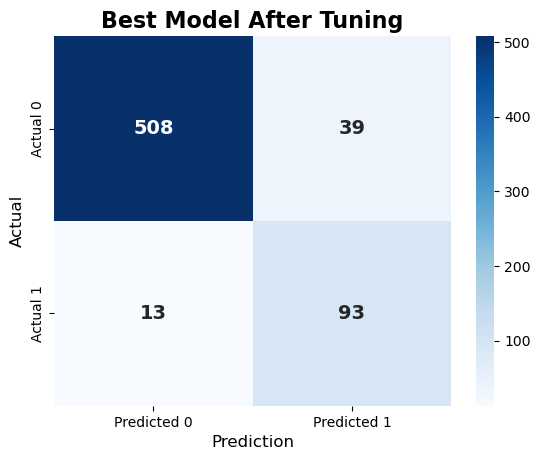

In [68]:
# Generate confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned_test)

# Plot the heatmap directly
sns.heatmap(cm_tuned, annot=True, fmt='.0f',
            cmap='Blues', annot_kws={'size': 14, 'weight': 'bold'},
            xticklabels=['Predicted 0', 'Predicted 1'],  # Customize x-axis labels
            yticklabels=['Actual 0', 'Actual 1'])       # Customize y-axis labels

# Add axis labels and title
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Best Model After Tuning', size=16, fontweight='bold')

# Adjust layout and display
plt.show()

### Summary of Classification Report

Based on the **classification report** from our model, we can summarize the potential business impact of using this churn prediction model to filter and target customers for retention campaigns:


### Key Metrics for Churn-Risk Customers (Class 1)

1. **F2-Score for Churn-Risk Customers**:
   - The **F2-score**, which prioritizes recall over precision, is the most relevant metric for this analysis as it focuses on minimizing false negatives. The model achieves an impressive **F2-score of 84%** on the test set, highlighting its effectiveness in identifying as many churn-risk customers as possible.

2. **Recall**:
   - The model has a **recall of 88%**, meaning it correctly identifies **88% of churn-risk customers** from the total pool of churn-risk customers.

3. **Precision**:
   - The model's **precision of 70%** means that when it predicts a customer is at risk of churn, there is a **70% chance the prediction is correct**. This leaves **30% of customers** who are not at risk but are predicted as churn-risk (false positives).

4. **F1-Score**:
   - For comparison, the **F1-score is 78%**, which balances precision and recall. However, since churn identification prioritizes recall, the **F2-score** better reflects the model's performance for this use case.

---

This analysis emphasizes that the model is highly effective at identifying churn-risk customers, particularly with its strong **F2-score of 84%**, making it well-suited for targeted retention campaigns.

### **Business Recommendations**


#### **1. Model Implementation for Marketing Department**

- This model as data solution is crucial because it ensures Ezora can **retain valuable customers** while avoiding excessive acquisition costs. By reducing churn, Ezora's marketing department can secure consistent revenue and improve overall profitability.

- If marketing department doesn’t adopt a targeted retention strategy, it risks losing 17% of its customers every month, increasing the financial strain on the marketing budget and risk its competitive position in the market.

- If churn continues, Ezora will need to spend even more on acquiring new customers, a cost that is already unsustainable (INR 1200–1500 per customer). This will reduce profit margins and hurt long-term growth.

- This solution should be implemented to the A/B testing as soon as possible because Ezora is under immediate financial pressure, and the model offers a way to optimize resources and ensure survival in the current economic climate.




#### **2. Conduct A/B Testing Before Deployment**
To ensure the model’s effectiveness and measurable business impact:
- **Step 1**: Use the model to identify churn-risk customers (treatment group).
- **Step 2**: Leave a control group unmanaged under business-as-usual conditions.
- **Step 3**: Implement targeted retention campaigns for the treatment group using cost-effective methods like **vouchers, bonuses, or cashback offers**.
- **Step 4**: Measure and compare churn rates between the treatment and control groups.

If the treatment group shows a statistically significant reduction in churn, proceed to full deployment. If results don’t meet expectations and haven't answer the business problems, re-visit the model to improve its performance.

#### **3. Long-Term Strategy and Improvements**
- **Improve Data Collection**:
  - Incorporate new features like customer engagement metrics (e.g., click rates, browsing time), customer unique identifier, customer spending for better predictions.
- **Automate Model Updates**:
  - Set up pipelines for periodic model retraining to adapt to changing customer behaviors.
- **Expand Campaign Testing**:
  - Test various retention strategies (e.g., email campaigns, discounts, loyalty points) to find the most effective interventions.


#### **Ezora Business Before and After Using the Model**

| **Scenario**             | **Before Using the Model**                               | **After Using the Model**                               |
|---------------------------|---------------------------------------------------------|--------------------------------------------------------|
| **Customer Acquisition**  | High costs (INR 1500 per customer) due to churn.   | Lower costs as retention reduces churn and boosts CLV. |
| **Retention Strategy**    | Blanket campaigns, high spending, and low efficiency.  | Targeted campaigns, optimized spending, and high ROI.  |
| **Marketing Budget**      | Wasted on non-churners and undifferentiated strategies. | Focused on at-risk customers, maximizing impact.       |


### CAC (Customer Acquisition Cost)
The **Customer Acquisition Cost (CAC)** is the cost incurred to acquire a new customer. For Ezora in 2024, the CAC is estimated to be INR 1500 per customer. This cost is allocated to : 

1. **Marketing and Advertising Costs**:
   - Online ads, social media campaigns, and email marketing efforts contribute to a significant portion of CAC.
2. **Sales Team Costs**:
   - Salaries and commissions for sales representatives involved in acquiring new customers.
3. **Onboarding and Initial Discounts**:
   - Onboarding support (customer service) and welcome discounts or vouchers for new customers.


### CRC (Customer Retention Cost)
The **Retention Cost** refers to the expense of keeping an existing customer and preventing churn. This cost is lower than CAC because it is more cost-effective to retain existing customers than acquire new ones. For Ezora in 2024, the CRC is estimated to be INR 1000 per customer, which allocated to : 

1. **Direct Retention Incentives**:
   - Cashback of INR 600 offered as part of a loyalty campaign.

2. **Marketing Costs**:
   - Email, SMS, or app notifications for personalized retention marketing campaigns.
   - Estimated cost per customer: INR 50.

3. **Customer Support**:
   - Retention calls or live chat support costs to address customer concerns and prevent churn.
   - Customer support cost per churn-risk customer = INR 150.

**Total Retention Cost = INR 600 (incentive) + INR 50 (marketing) + INR 150 (support) = INR 800.**


### CLV (Customer Lifetime Value)

The **Customer Lifetime Value (CLV)** is an estimate of the total revenue a customer is expected to generate for the business during their relationship. For Ezora, the CLV is estimated at `INR 5,000` per customer.

#### **1. Blanket Campaign (Before Using Model)**
In a blanket campaign, retention efforts are applied to **all customers**, regardless of churn risk.

- **Total Customers**: 653
- **Retention Cost per Customer**: INR 800
- **Total Campaign Cost**:
 `653 customers x INR 800 = INR 522,400`
- **Total Custommer Churned**
 `653 customers x 17% = 111 customers`

If these 111 churners are not retained, the business must replace them with new customers.
- **Total CAC for Replacing Churners:**
`111 customers × INR 1,500 = INR 166,500.`

#### **2. Targeted Campaign (After Using Model)**
Using the model to target only at-risk customers improves efficiency.

1. **True Churners Retained**:
   - 93 true churners are identified and targeted by the model (True Positives).

2. **False Positives**:
   - 39 non-churners are mistakenly targeted (False Positives).

3. **Total Customers Targeted**:
`True Churners (93) + False Positives (39) = 132 customers`

4. **Retention Cost per Customer**: INR 800

5. **Total Campaign Cost**:
`132 customers x INR 800 = INR 105,600.`

6. **False Negatives (Missed Churners)**:
- 13 churners are missed by the model (False Negatives), representing potential revenue loss.

7. **Potential Revenue Loss Due to FN**:  
`13 customers × INR 5,000 (CLV) = INR 65,000.`

8. **CAC for Replacing Missed Churners**:  
`13 customers × INR 1,500 (CAC) = INR 19,500.`

9. **Net Savings**:  

**Blanket Campaign Cost - (Targeted Campaign Cost + FN Loss + FN CAC Cost)**<br>
`= INR 522,400 - (INR 105,600 + INR 65,000 + INR 19,500)`
`= INR 332,300.`


#### **Cost Comparison**


| Metric                       | Blanket Campaign        | Targeted Campaign      |
|------------------------------|-------------------------|------------------------|
| **Total Customers Targeted** | 653                    | 132                    |
| **Retention Cost**           | INR 522,400            | INR 190,100            |
| **Net Savings**               | -                      | INR 332,300            |
| **Efficiency**               | Low (no filtering)     | High (targeted effort) |

From a business perspective, Ezora can observe that:

1. By using machine learning, Ezora can save **79.2%** of promotional costs.

2. **Net Savings** have significantly increased to `INR 332,300`, demonstrating a substantial positive impact from implementing the ML model.

3. **Total Cost of ML Implementation Impact** = Promotional Cost with ML + Potential Loss from FN =  
`INR 105,600 + INR 65,000 = INR 170,600`

4. **ROI** = (Net Savings / Total Cost of ML Implementation) × 100: 
`ROI = (INR 332,300 / INR 170,600) × 100 ≈ 194.8% `

---

With an impressive ROI of **194.8%**, Ezora is well-positioned to not only reduce costs and improve short-term profitability but also reinvest the savings into strategic initiatives for long-term growth. This analysis highlights that implementing machine learning is not merely a cost-saving measure but a powerful enabler for sustainable business transformation.

### **Model Recommendations**


### When to Use and Not Use the Model

The model provides reliable predictions in identifying churn-risk customers under certain conditions, but it also has limitations that should be considered:

**When the Model Can Be Trusted**:
1. **Strong Feature Influence**:
   - The model performs well when features like `Tenure`, `CashbackAmount`, and `Complain` dominate in influencing churn. These features provide clear signals for predicting customer behavior.
2. **High Recall Requirement**:
   - The model's high recall (88%) ensures it captures most churn-risk customers, making it particularly effective for campaigns where minimizing missed churners is critical.
3. **Balanced Campaign Cost**:
   - The targeted retention strategy effectively reduces costs compared to a blanket campaign, achieving significant savings with a net benefit.

**When the Model Should Be Used with Caution**:
1. **Different Cases in Feature Behavior**:
   - For customers with atypical or missing values in influential features (e.g., very short `Tenure`, or outside 0-60 months tenure), the model's predictions may be less reliable.
2. **False Positive Costs**:
   - If the business cannot afford the campaign costs for false positives (30% of predicted churners), the model's precision (70%) may not align with strategic goals.
3. **Over-Reliance on Limited Features**:
   - The model's reliance on a small set of features could limit its accuracy if new features influencing churn are introduced or if feature dictionary change or increase over time.

### Future Improvements and Recommendations

1. **Data Quality and Feature Expansion**:
   - Since `Tenure`, `Complain`, and `NumberOfAddress` are the top influential features based on SHAP analysis, ensuring the accuracy and completeness of these variables is critical. Any missing or incorrect data in these features could significantly affect the model's predictions.
   - Collect additional data points to complement the existing features. For instance:
     - **Customer engagement metrics**: How often customers interact with the platform or respond to marketing.
     - **Product-level details**: Insights into customer preferences for specific product categories.
     - **Behavioral patterns**: Such as abandoned cart rates or browsing history.
   - The feature `CashbackAmount` shows a high impact on churn. Explore introducing features that capture variations in cashback policies or trends over time (e.g., frequency of cashback usage or average cashback received per order).

2. **Long-Term Monitoring**:
   - Monitor how the impact of features changes over time. For example, as cashback policies or product delivery options changes, the importance of `CashbackAmount` or `WarehouseToHome` may fluctuate.
   - Periodically re-train the model with updated data to account for shifts in customer behavior or market dynamics.

3. **Targeted Campaign Segmentation**:
   - Given that `SatisfactionScore` is also a moderately influential feature, consider segmenting retention campaigns based on satisfaction levels to tailor promotional efforts more effectively.
   - Use features like `PreferredOrderCategory` (`Laptop & Accessories`, `Grocery`, etc.) to further personalize campaigns, focusing efforts on customers most likely to churn within specific product segments.

By focusing on these key areas, Ezora can improve model performance and enhance its ability to predict and prevent customer churn while ensuring the model remains relevant and robust in a dynamic market environment.

### **References**




[Customer Retention1](https://churnkey.co/blog/retention-metrics-to-reduce-churn-and-win-back-customers/)

[Customer Retention2](https://www.bain.com/insights/retaining-customers-is-the-real-challenge/)

[Customer Acquisition2](https://userpilot.com/blog/average-customer-acquisition-cost/?utm_source=chatgpt.com)

[Customer Acquisition2](https://www.gokwik.co/blog/reduce-customer-acquisition-cost#)

[E-Commerce](https://www.forbes.com/councils/forbesagencycouncil/2024/02/16/12-ways-e-commerce-companies-can-boost-d2c-sales-with-ai/)

[LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/Parameters-Tuning.html)


[XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html)

[XGBoost2](https://stackoverflow.com/questions/42192227/xgboost-python-classifier-class-weight-option
)
